In [2]:

# Heavily borrows from https://github.com/Priesemann-Group/covid19_inference

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

import pandas as pd
import datetime

import pymc3 as pm

import pickle
import datetime

import theano
import theano.tensor as tt
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"




## single Case Overview

| time | event | distribution | RKI |
|------|-------|--------------|-----|
| -4 | infected | |
| -2... | infectious | lognormal | 
| 0...2 | onset of illness | | RefDate |
| +x | tested | | Meldedatum |
| x+y | reported to RKI | | first appearence in DB |

* number of RefDate is epidemic curve (EpiCurve), i.e. number with cases of onset of illness known on a given date
* numner of infections on a date is roughly EpiCurve shifted forward 4-5 days
* Reported Meldedatum not the date, the data appears in the RKI-Dataset, but Meldung to lower-level-authorities


In [363]:
trace = pickle.load(open("../traces/trace211104.dat","rb"))
with open("../data/onset_by_date.pickle","rb") as f:
    onsets_per_date = pickle.load(f)
    
print(trace)
print(trace.lambda_t_random_walk.shape)
print(trace.lambda_t.shape)
print(np.mean(trace.infected_t,axis=0)[:40])
trace.varnames

<MultiTrace: 2 chains, 200 iterations, 33 variables>
(400, 83)
(400, 83)
[  68.53266745   67.79479626   65.08121723   67.29346822   79.39002513
  115.12534531  160.97384067  175.35422684  178.73466122  162.30826777
  166.62578944  236.87514224  262.06860698  332.58104325  379.75265223
  489.01436742  801.68937446  954.57394825 1437.39666829 2039.83639021
 2470.93104202 2742.17552541 3102.50643466 3983.82445109 2683.31303802
 4164.70085117 3643.05312325 4417.84710705 3045.05009626 3341.16012005
 5353.00380386   20.86421553 4157.13701863 2497.15824619 2999.60580231
 3507.80483339 1424.64156666 4374.76033081  818.85628092 2461.34538007]


['lambda_0_log__',
 'sigma_random_walk_log__',
 'lambda_t_random_walk',
 'initial_a1_log__',
 'initial_a2_log__',
 'delay_ratio_0_interval__',
 'delay_ratio_t_sigma_random_walk_log__',
 'delay_ratio_t_random_walk',
 'f_unknown_log__',
 'delay_m1_log__',
 'delay_s1_log__',
 'delay_s2_log__',
 'sigma_onset_obs_log__',
 'new_day_curve_studentT_missing',
 'lambda_0',
 'sigma_random_walk',
 'initial_a1',
 'initial_a2',
 'initial_t',
 'lambda_t',
 'delay_ratio_0',
 'delay_ratio_t_sigma_random_walk',
 'delay_ratio_t',
 'f_unknown',
 'infected_t',
 'onset_of_illness_t',
 'delay_m1',
 'delay_s1',
 'delay_s2',
 'reported_t',
 'per_day_curve_t',
 'per_day_curve_s',
 'sigma_onset_obs']

(83, 210) (2, 83, 66)


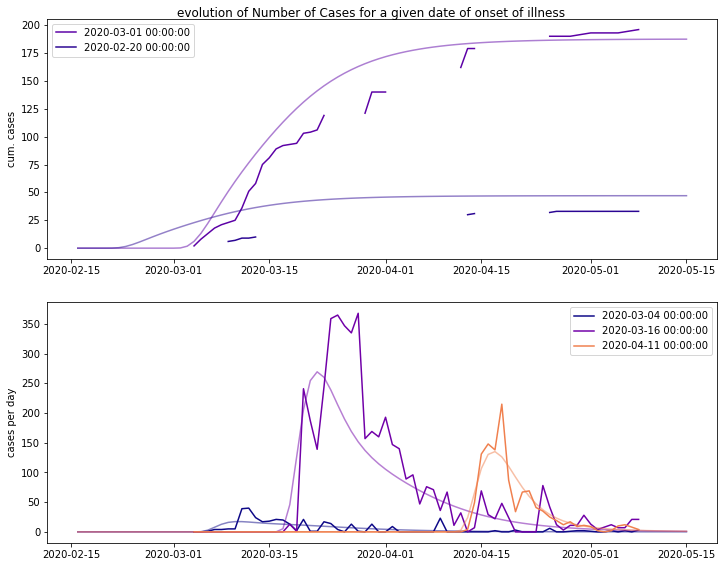

In [370]:
ta = pd.date_range(datetime.date(2020,2,16), periods=120, freq='D')


fig, axes = plt.subplots(2,1 , figsize = (10,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.18,left=0.05,right=0.98,top=0.96,bottom=0.05)
ax = axes[0,0]
bx = axes[1,0]
plasma = plt.cm.plasma


#print(trace.per_day_curve)

pdd = np.mean(trace.per_day_curve_t,axis=0)
pdc,pdcs = np.cumsum(pdd,axis=1),np.percentile(trace.per_day_curve_s,axis=0,q=(12.5,87.5))

print(pdc.shape,pdcs.shape)
#for i in reversed(range(pdc.shape[1])[0:83:7]):
for i in reversed(range(pdc.shape[1])[4:20:10]):
    c = plasma(i/85)
    ax.plot(ta[17:66+17],onsets_per_date[:][i],color=c,label=ta[i])
    
    ax.plot(ta[:90],pdc[i][:90],color=c,alpha=.5)
   # ax.fill_between(ta[17:66+17],*(pdcs[:,i]),color=c,alpha=.2)

for i in [17,29,55]:
    c = plasma((i-17)/(55))
    bx.plot(ta[17:66+17],np.concatenate([[0],np.diff(onsets_per_date[:][i])]),color=c,label=ta[i])
    bx.plot(ta[:90],pdd[i][:90],color=c,alpha=.5)
ax.set_ylabel("cum. cases")
bx.set_ylabel("cases per day")
fig.suptitle("evolution of Number of Cases for a given date of onset of illness")
_= ax.legend()
_= bx.legend()

## Model overview
* intial distribution of imported cases
* weekly priors for R_eff and delay_ratio, smoothed (3 day window/linear interpolation)
* model reporting-delay i.e. time till case appears in RKI-database
* for each day, generate distribution, when cases appear as 'onset known' in RKI-database
* observation: for each date: vector of 'onset knwon' by date they appear in RKI-database
* Hope is to estimate current reporting-delay
* side project: delay cases to generate death/day

**Only models based on known onsets of illness!**


AttributeError: 'MultiTrace' object has no attribute 'dead_t'

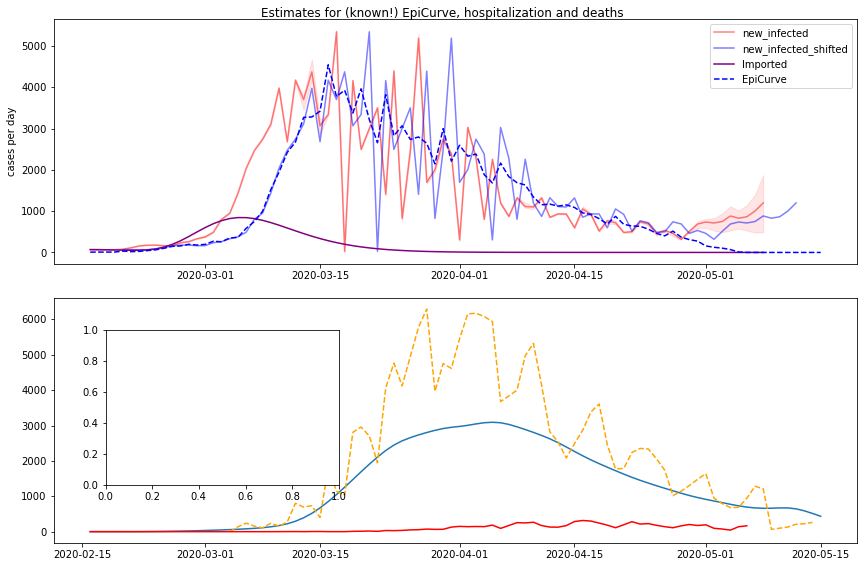

In [362]:
dtx = [datetime.date(2020,3,1),datetime.date(2020,3,15),datetime.date(2020,4,1),datetime.date(2020,4,15),datetime.date(2020,5,1)]

epi_curve = [7, 9, 8, 10, 33, 19, 26, 45, 64, 102, 147, 158, 197, 179, 195, 272, 258, 350, 366, 585, 747, 997, 1521, 1944, 2421, 2672, 3272, 3282, 3422, 4546, 3778, 3929, 3376, 3964, 3220, 2659, 3822, 2826, 3069, 2737, 2798, 2644, 2144, 2999, 2210, 2597, 2332, 2384, 1886, 1683, 2165, 1835, 1689, 1635, 1342, 1154, 1171, 1122, 1152, 1090, 959, 919, 819, 689, 874, 681, 641, 634, 564, 460, 402, 516, 370, 310, 274, 158, 125, 104, 69, 11, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
epi_curve = np.array(epi_curve,dtype=np.float64)
rki_reported = [0,138,239,156,107,237,157,271,802,693,733,400,1817,1144,1036,2807,2958,2705,1948,4062,4764,4118,4954,5780,6294,3965,4751,4615,5453,6156,6174,6082,5936,3677,3834,4003,4974,5323,4133,2821,2537,2082,2486,2866,3380,3609,2458,1775,1785,2237,2352,2337,2055,1737,1018,1144,1304,1478,1639,945,793,679,685,947,1284,1209,64,97,130,209,223,262]
rki_reported = np.array(rki_reported)
deaths = [-1]*17+[-1,-1,-1,-1,-1,-1,0,1,2,0,3,4,0,0,0,8,11,16,8,31,28,35,49,55,72,64,66,128,149,140,145,141,184,92,173,254,246,266,171,129,126,170,285,315,299,242,184,110,194,281,215,227,179,140,110,163,202,173,193,94,74,43,139,165]#deaths = [0]*4+deaths
deaths = np.asarray(deaths,dtype=np.float64)

fig, axes = plt.subplots(2, 1, figsize = (12,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.05,right=0.98,top=0.96,bottom=0.05)
fig.suptitle('Estimates for (known!) EpiCurve, hospitalization and deaths')
ax = axes[0,0]
bx = axes[1,0]
cx = fig.add_axes([.11,.15,.27,.27])

ax.plot(ta[:83],np.median(trace.infected_t,axis=0),color="red",alpha=.5,label="new_infected")
ax.plot(ta[4:83+4],np.median(trace.infected_t,axis=0),color="blue",alpha=.5,label="new_infected_shifted")
ax.fill_between(ta[:83],*np.percentile(trace.infected_t, axis=0, q=(12.5,87.5)),color="red",alpha=.1)

ax.plot(ta[:83],np.median(trace.initial_t,axis=0),c="purple",label="Imported")
bx.plot(ta[:90],np.sum(np.mean(trace.per_day_curve_t,axis=0),axis=0)[:90],label="reported")
#ax.plot(ta[17:83],*(np.percentile(trace.per_day_curve_s,axis=0,q=(12.5,87.5))) )

ax.plot(ta[:len(epi_curve)],epi_curve,"--",color="blue",label="EpiCurve")
bx.plot(ta[17:17+len(rki_reported)],rki_reported,"--",color="orange",label="reported")
rki_reported

ax.set_ylabel("cases per day")
ax.legend(loc=1)
ax.set_xticks(dtx)
ax.set_xticklabels(dtx)

if True:
    bx.plot(ta[:len(deaths)],deaths,color="red",label="deaths")
    bx.plot(ta[:83],np.median(trace.dead_t,axis=0),color="orange")
    bx.fill_between(ta[:83],*np.percentile(trace.dead_t, axis=0, q=(12.5,87.5)),color="orange",alpha=.2)

bx.set_ylabel("cases per day")
bx.legend(loc=1)
bx.set_xticks(dtx)
bx.set_xticklabels(dtx)


cx.set_title("R_eff")
cx.plot(ta[:len(trace.lambda_t[0])],np.median(trace.lambda_t,axis=0))
cx.fill_between(ta[:len(trace.lambda_t[0])],*np.percentile(trace.lambda_t, axis=0, q=(12.5,87.5)),color="blue",alpha=.1)
cx.set_xticks(dtx)
_ = cx.set_xticklabels(dtx,rotation=20,horizontalalignment='right')

delay_m1 7.74 0.106
delay_s1 0.41 0.010
delay_s2 0.47 0.033
delay_m2 fixed to 20.000
50 precent known after 8 days after incubation


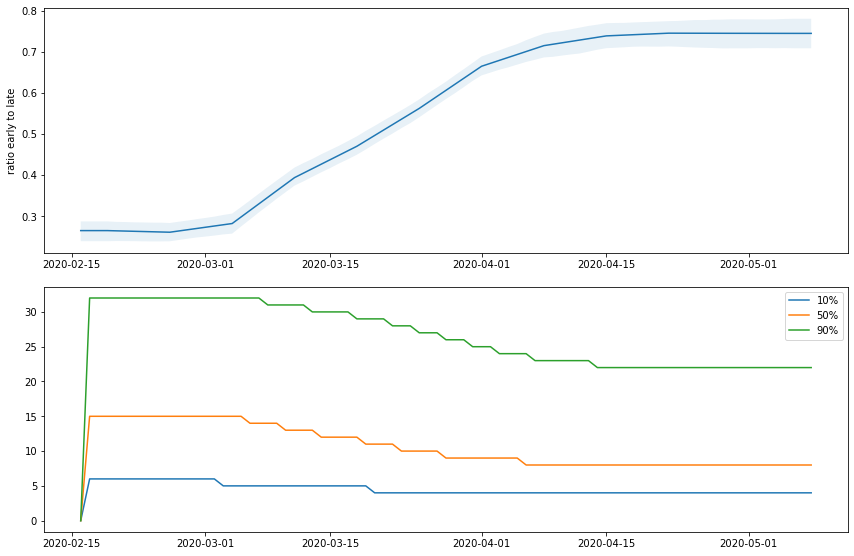

In [354]:
def tt_lognormal(x, mu, sigma):
    x = tt.clip(x,1e-12,1e12) # Checks to improve stability and resilience against NANs
    
    distr = 1/x* tt.exp(-((tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=0)+1e-9)

def reportDelayDist(x, mu1, sig1, mu2, sig2, r ):
    x = tt.clip(x,1e-12,1e12) # Checks to improve stability and resilience against NANs
    r = tt.clip(r,0,1)
    d1 = tt_lognormal(x,mu1,sig1)
    d2 = tt_lognormal(x,mu2,sig2)
    
    ds = r*d1 + (1-r)*d2
    
    return ds / (tt.sum(ds) + 1e-12)



v = ["delay_m1","delay_s1","delay_s2"]
for n in v:
    print(n,"%.2f %.3f"%(np.mean(trace[n],axis=0),np.std(trace[n],axis=0)))
print("delay_m2 fixed to %.3f"%20)

m1,m2,s1,s2 = np.mean(trace.delay_m1,axis=0),20,np.mean(trace.delay_s1,axis=0),np.mean(trace.delay_s2,axis=0)

fig, axes = plt.subplots(2, 1, figsize = (12,8),squeeze=False)
fig.subplots_adjust(wspace=0.15,hspace=0.14,left=0.05,right=0.98,top=0.96,bottom=0.05)
ax = axes[0,0]
bx = axes[1,0]
dlr = np.mean(trace.delay_ratio_t,axis=0)
ax.plot(ta[:83],dlr)
ax.fill_between(ta[:83],*np.percentile(trace.delay_ratio_t,axis=0,q=(12.5,87.5)),alpha=.1)

ax.set_ylabel("ratio early to late")

py = {10:[0]*83,50:[0]*83,90:[0]*83}
for i in range(83):
    d = pdc[i]
    m = d[-1]
    for j,dj in enumerate(d):
        if dj < m*.1:
            py[10][i] = j-i+1
        if dj < m*.5:
            py[50][i] = j-i+1
        if dj < m*.9:
            py[90][i] = j-i+1

bx.plot(ta[:83],py[10],label="10%")
bx.plot(ta[:83],py[50],label="50%")
bx.plot(ta[:83],py[90],label="90%")
bx.legend()

print("50 precent known after %d days after incubation"%py[50][-1])
#    print(dlr[i])
#    print(reportDelayDist(np.arange(60),m1,s1,m2,s2,dlr[i]))
#    bx.plot()